In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from torch import nn, optim

from pack2.utils import get_dataset

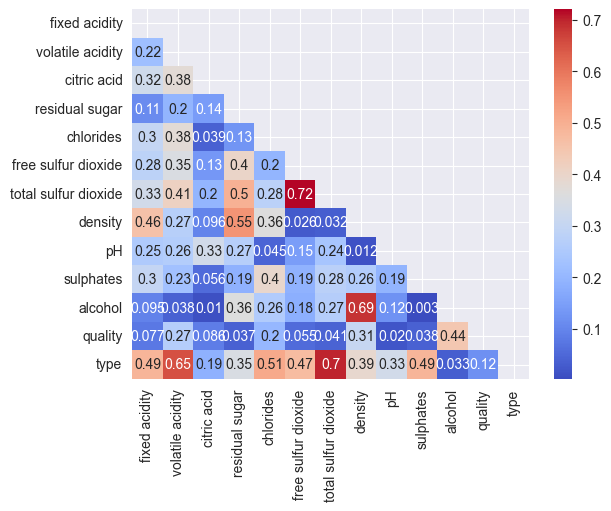

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
df = get_dataset()

y = df.pop("quality").values
X = df.values
tmp = []
for i in y:
    t = [0] * 10
    t[i] = 1
    tmp.append(t)
y = tmp

In [3]:
from torch.utils.data import TensorDataset, DataLoader

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, shuffle=True
)

X_train = torch.tensor(X_train, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

input_size = X_train.shape[1]

In [4]:
model = nn.Sequential(
    nn.Linear(input_size, 256),
    nn.ReLU(),
    nn.Linear(256, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 10),
).to(device)

n_epochs = 1000
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [5]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_quality = []
    with torch.no_grad():
        for features, quality in loader:
            features, quality = features.to(device), quality.to(device)
            outputs = model(features)
            _, preds = torch.max(outputs, 1)
            _, quality = torch.max(quality, 1)
            correct += (preds == quality).sum().item()
            total += quality.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_quality.extend(quality.cpu().numpy())
    accuracy = correct / total * 100
    return accuracy, np.array(all_quality), np.array(all_preds)


In [6]:

from tqdm import tqdm

train_loss_history = []
test_accuracy_history = []
test_loss_history = []


for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_loss_history.append(epoch_loss)

    test_accuracy, _, _ = evaluate(model, test_loader)
    test_accuracy_history.append(test_accuracy)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{n_epochs}, Loss: {epoch_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")



Epoch 0/1000, Loss: 1.5472, Test Accuracy: 43.49%
Epoch 10/1000, Loss: 1.1555, Test Accuracy: 47.59%
Epoch 20/1000, Loss: 1.0954, Test Accuracy: 49.18%
Epoch 30/1000, Loss: 1.0744, Test Accuracy: 50.10%
Epoch 40/1000, Loss: 1.0467, Test Accuracy: 49.64%
Epoch 50/1000, Loss: 1.0337, Test Accuracy: 50.82%
Epoch 60/1000, Loss: 1.0112, Test Accuracy: 52.00%
Epoch 70/1000, Loss: 0.9907, Test Accuracy: 51.74%
Epoch 80/1000, Loss: 0.9698, Test Accuracy: 47.64%
Epoch 90/1000, Loss: 0.9489, Test Accuracy: 52.46%
Epoch 100/1000, Loss: 0.9154, Test Accuracy: 51.69%
Epoch 110/1000, Loss: 0.8939, Test Accuracy: 52.26%
Epoch 120/1000, Loss: 0.8810, Test Accuracy: 51.85%
Epoch 130/1000, Loss: 0.8493, Test Accuracy: 53.79%
Epoch 140/1000, Loss: 0.8214, Test Accuracy: 51.59%
Epoch 150/1000, Loss: 0.7975, Test Accuracy: 54.00%
Epoch 160/1000, Loss: 0.8398, Test Accuracy: 53.49%
Epoch 170/1000, Loss: 0.7573, Test Accuracy: 53.33%
Epoch 180/1000, Loss: 0.7430, Test Accuracy: 51.64%
Epoch 190/1000, Loss: 0

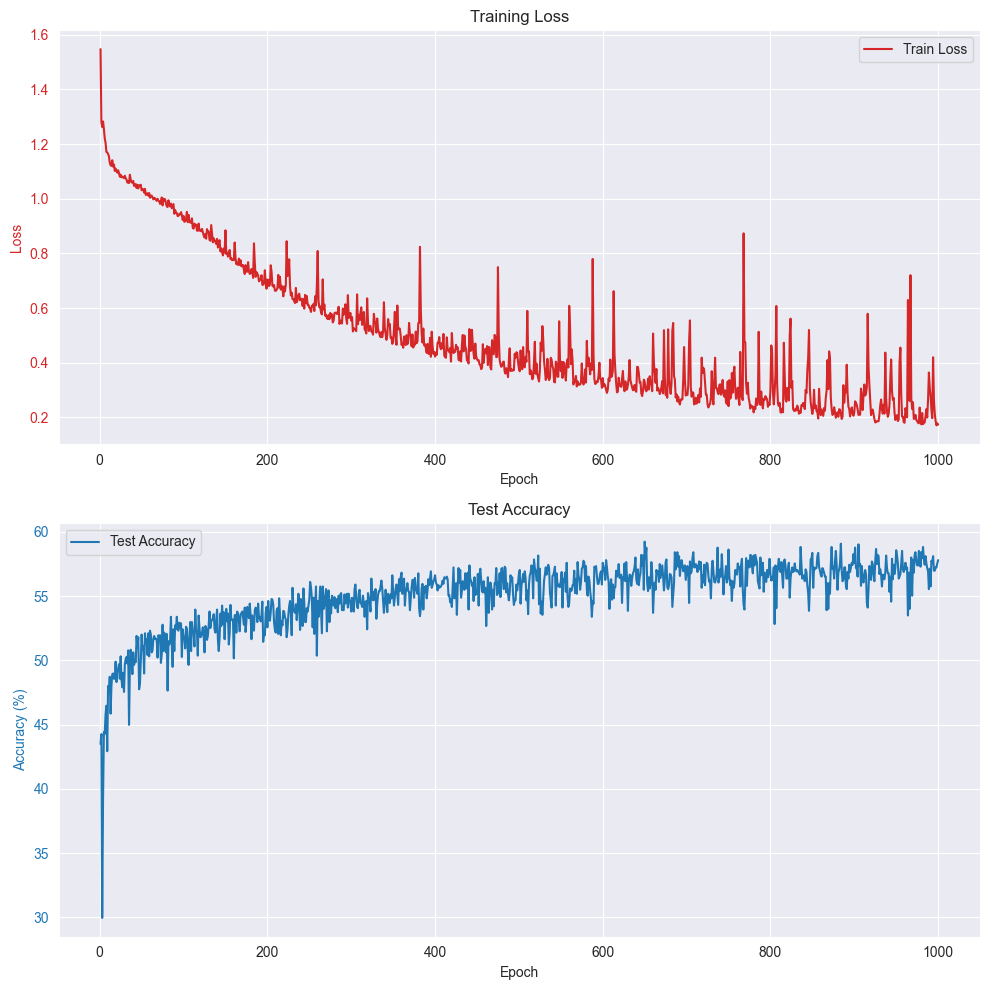

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(1, n_epochs + 1), train_loss_history, color=color, label='Train Loss')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper right')
ax1.set_title("Training Loss")

color = 'tab:blue'
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)', color=color)
ax2.plot(range(1, n_epochs + 1), test_accuracy_history, color=color, label='Test Accuracy')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper left')
ax2.set_title("Test Accuracy")

plt.tight_layout()
plt.show()

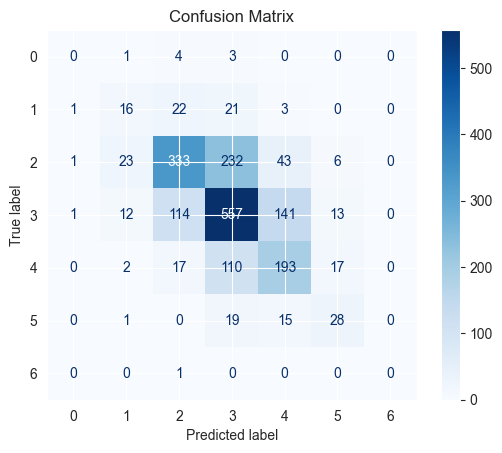

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

_, y_true, y_pred = evaluate(model, test_loader)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()



In [9]:
import pandas as pd

model.eval()
x = X_test
y_expected = y_test
y_pred = model(x)
res = {
    "prediction": [],
    "expected": [],
}
for i in range(len(y_pred)):
    res['prediction'].append(y_pred[i].detach().numpy().argmax())
    res['expected'].append(y_expected[i].detach().numpy().argmax())

df = pd.DataFrame(
    res
)

df


,prediction,expected
0,6,6
1,6,6
2,6,5
3,6,7
4,5,5
...,...,...
1945,5,6
1946,6,6
1947,4,5
1948,6,5


In [10]:
from sklearn.metrics import classification_report

report = classification_report(res["expected"], res["prediction"], zero_division=0)
print(report)

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         8
           4       0.29      0.25      0.27        63
           5       0.68      0.52      0.59       638
           6       0.59      0.66      0.63       838
           7       0.49      0.57      0.53       339
           8       0.44      0.44      0.44        63
           9       0.00      0.00      0.00         1

    accuracy                           0.58      1950
   macro avg       0.36      0.35      0.35      1950
weighted avg       0.58      0.58      0.58      1950

